In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Configuración: ruta a los archivos daily_reports locales
# Nota: el notebook está en notebooks/, por eso usamos '../' para subir un nivel
DATA_DIR = os.path.join('..', 'data', 'raw', 'COVID-19', 'csse_covid_19_data', 'csse_covid_19_daily_reports')

# Rango de fechas a cargar (enero a junio 2020)
dates = pd.date_range(start='2020-01-22', end='2020-06-30', freq='D')

# Lista temporal para acumular los DataFrames de cada día
dfs = []

print("Cargando datos desde archivos locales...")
print(f"{'='*60}")

# Leer cada archivo CSV diario y agregarlo a la lista
for date in dates:
    filename = date.strftime('%m-%d-%Y') + '.csv'  # Formato: MM-DD-YYYY
    filepath = os.path.join(DATA_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠ Archivo no encontrado: {filename}")
        continue
    
    try:
        df = pd.read_csv(filepath)
        df.columns = df.columns.str.strip()
        
        # Normalizar nombres de columnas para compatibilidad
        if 'Province/State' in df.columns:
            df.rename(columns={'Province/State': 'Province_State'}, inplace=True)
        if 'Country/Region' in df.columns:
            df.rename(columns={'Country/Region': 'Country_Region'}, inplace=True)
        if 'Province_State' not in df.columns:
            df['Province_State'] = np.nan
        if 'Country_Region' not in df.columns and 'Country' in df.columns:
            df.rename(columns={'Country': 'Country_Region'}, inplace=True)
        
        df['Date'] = date
        dfs.append(df)
        
        # Mostrar progreso cada 30 días
        if len(dfs) % 30 == 0:
            print(f"✓ Cargados {len(dfs)} archivos...")
            
    except Exception as e:
        print(f"✗ Error en {filename}: {e}")

# Concatenar (apilar verticalmente) todos los DataFrames diarios en uno solo
if dfs:
    df_6meses = pd.concat(dfs, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"✓ Cargados {len(dfs)} archivos diarios")
    print(f"✓ Total de registros: {len(df_6meses):,}")
    print(f"✓ Período: {df_6meses['Date'].min().date()} → {df_6meses['Date'].max().date()}")
    print(f"{'='*60}")
else:
    df_6meses = pd.DataFrame()
    print("\n⚠ No se cargó ningún archivo.")
    print("Ejecuta: ./scripts/fetch_jhu_data.sh clone")

Cargando datos desde archivos locales...
✓ Cargados 30 archivos...
✓ Cargados 60 archivos...
✓ Cargados 90 archivos...
✓ Cargados 120 archivos...
✓ Cargados 90 archivos...
✓ Cargados 120 archivos...
✓ Cargados 150 archivos...

✓ Cargados 161 archivos diarios
✓ Total de registros: 350,945
✓ Período: 2020-01-22 → 2020-06-30
✓ Cargados 150 archivos...

✓ Cargados 161 archivos diarios
✓ Total de registros: 350,945
✓ Período: 2020-01-22 → 2020-06-30


In [2]:
# Limpieza y preparación del dataset

# 1. Estandarizar nombres de columnas (usar formato snake_case)
df_6meses.columns = df_6meses.columns.str.lower().str.replace(' ', '_').str.replace('/', '_').str.replace('-', '_')

# 2. Eliminar columnas duplicadas (consolidando valores)
# Los archivos tienen diferentes esquemas que pueden generar columnas duplicadas
duplicated_cols = df_6meses.columns[df_6meses.columns.duplicated()].unique()

if len(duplicated_cols) > 0:
    print(f"⚠ Encontradas columnas duplicadas: {duplicated_cols.tolist()}")
    
    for col_name in duplicated_cols:
        # Obtener todas las columnas con este nombre
        matching_cols = [i for i, c in enumerate(df_6meses.columns) if c == col_name]
        
        # Consolidar: tomar el primer valor no nulo de cada fila
        consolidated = df_6meses.iloc[:, matching_cols[0]]
        for col_idx in matching_cols[1:]:
            consolidated = consolidated.fillna(df_6meses.iloc[:, col_idx])
        
        # Eliminar todas las columnas duplicadas
        df_6meses = df_6meses.drop(df_6meses.columns[matching_cols], axis=1)
        
        # Agregar la columna consolidada
        df_6meses[col_name] = consolidated
        print(f"  ✓ '{col_name}' consolidada")

# 3. Eliminar columnas irrelevantes
columns_to_drop = ['fips', 'admin2', 'lat', 'long_', 'latitude', 'longitude', 'combined_key']
df_6meses = df_6meses.drop(columns=[col for col in columns_to_drop if col in df_6meses.columns])

# 4. Procesar fechas
if 'last_update' in df_6meses.columns:
    df_6meses['last_update'] = pd.to_datetime(df_6meses['last_update'], errors='coerce')

# 5. Convertir columnas numéricas
numeric_columns = ['confirmed', 'deaths', 'recovered']
for col in numeric_columns:
    if col in df_6meses.columns:
        df_6meses[col] = pd.to_numeric(df_6meses[col], errors='coerce').fillna(0).astype(int)

# 6. Calcular casos activos
df_6meses['active_cases'] = df_6meses['confirmed'] - df_6meses['deaths'] - df_6meses['recovered']

# 7. Homogeneizar nombres de países
country_mapping = {
    'US': 'United States',
    'UK': 'United Kingdom',
    'Korea, South': 'South Korea',
    'Taiwan*': 'Taiwan',
    'Mainland China': 'China'
}

if 'country_region' in df_6meses.columns:
    df_6meses['country_region'] = df_6meses['country_region'].replace(country_mapping)

print(f"\n✓ Dataset limpio: {len(df_6meses):,} registros")
print(f"✓ Columnas finales: {df_6meses.columns.tolist()}")
df_6meses.head()

⚠ Encontradas columnas duplicadas: ['last_update']
  ✓ 'last_update' consolidada

✓ Dataset limpio: 350,945 registros
✓ Columnas finales: ['province_state', 'country_region', 'confirmed', 'deaths', 'recovered', 'date', 'active', 'incidence_rate', 'case_fatality_ratio', 'last_update', 'active_cases']

✓ Dataset limpio: 350,945 registros
✓ Columnas finales: ['province_state', 'country_region', 'confirmed', 'deaths', 'recovered', 'date', 'active', 'incidence_rate', 'case_fatality_ratio', 'last_update', 'active_cases']


province_state country_region  confirmed  deaths  recovered       date  \
0          Anhui          China          1       0          0 2020-01-22   
1        Beijing          China         14       0          0 2020-01-22   
2      Chongqing          China          6       0          0 2020-01-22   
3         Fujian          China          1       0          0 2020-01-22   
4          Gansu          China          0       0          0 2020-01-22   

   active  incidence_rate  case_fatality_ratio         last_update  \
0     NaN             NaN                  NaN 2020-01-22 17:00:00   
1     NaN             NaN                  NaN 2020-01-22 17:00:00   
2     NaN             NaN                  NaN 2020-01-22 17:00:00   
3     NaN             NaN                  NaN 2020-01-22 17:00:00   
4     NaN             NaN                  NaN 2020-01-22 17:00:00   

   active_cases  
0             1  
1            14  
2             6  
3             1  
4             0

Top 10 países con más casos confirmados:
country_region
Russia            405843
United Kingdom    290143
Brazil            281380
India             276146
Spain             236899
Iran              227662
Italy             222104
Chile             219151
United States     215179
Turkey            199906
Name: confirmed, dtype: int64


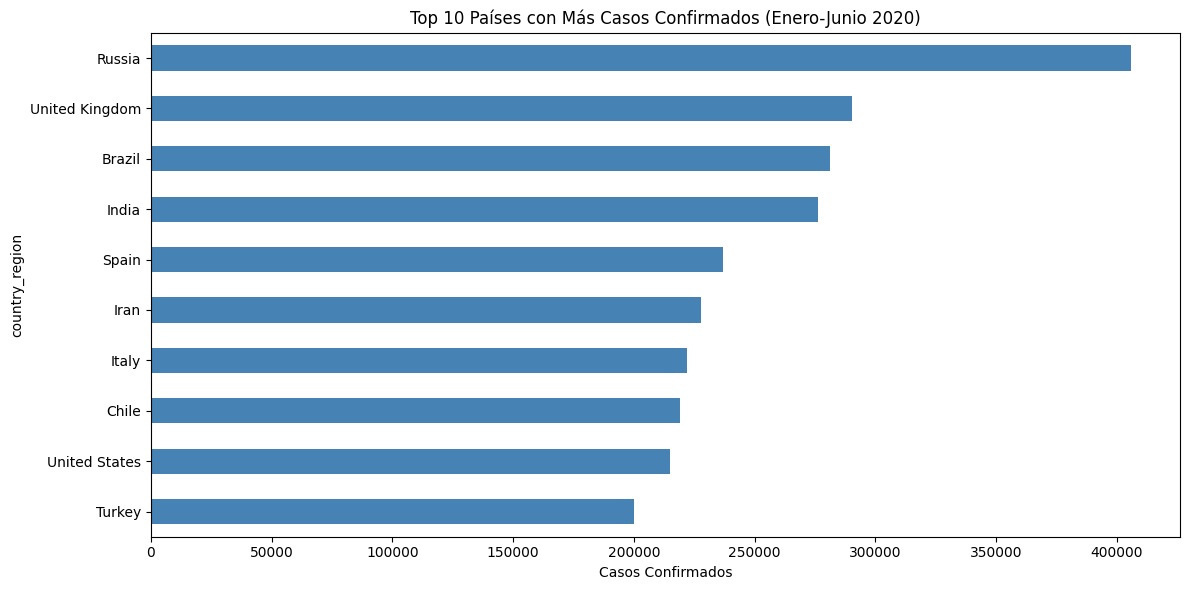

In [3]:
# 1. ¿Cuáles son los 10 países con más casos confirmados acumulados durante el semestre?
top_10_paises = df_6meses.groupby('country_region')['confirmed'].max().sort_values(ascending=False).head(10)
print("Top 10 países con más casos confirmados:")
print(top_10_paises)

plt.figure(figsize=(12, 6))
top_10_paises.plot(kind='barh', color='steelblue')
plt.xlabel('Casos Confirmados')
plt.title('Top 10 Países con Más Casos Confirmados (Enero-Junio 2020)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Top 10 países con mayor tasa de letalidad (mínimo 1000 casos):
     country_region  confirmed  deaths  letalidad
239           Yemen       1158     312  26.943005
229  United Kingdom     290143   48628  16.760011
20          Belgium      61427    9747  15.867615
74           France     196554   29763  15.142404
98          Hungary       4155     585  14.079422
107           Italy     222104   31106  14.005151
152     Netherlands      50273    6113  12.159609
142          Mexico      54346    6560  12.070806
168            Peru     158189   18591  11.752397
203           Spain     236899   27104  11.441163


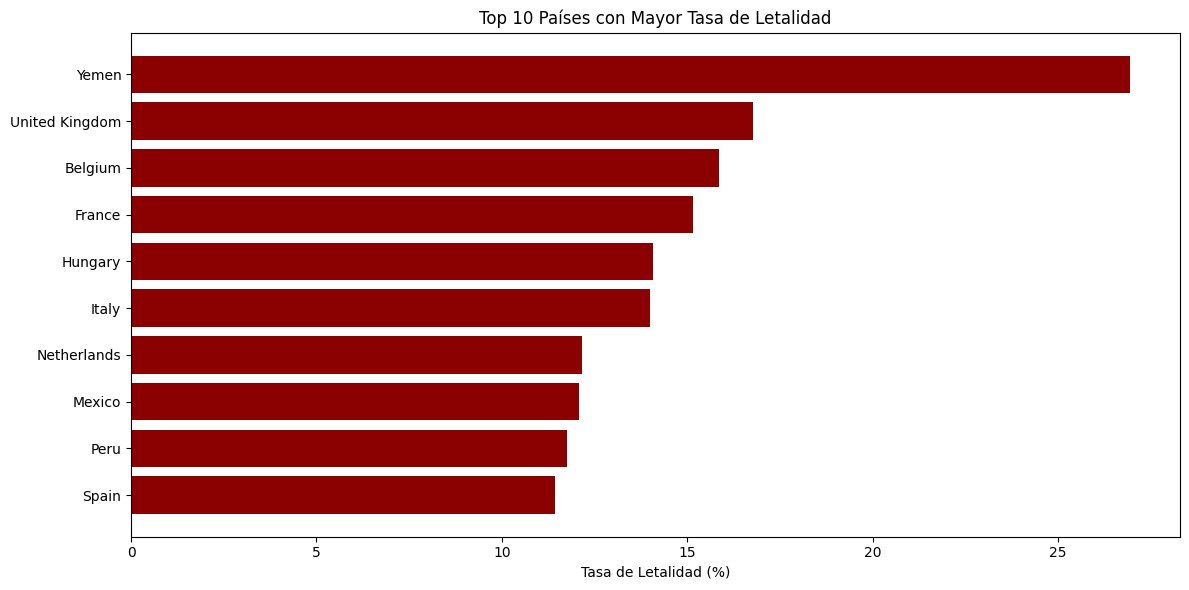

In [4]:
# 2. ¿Qué países presentan mayor tasa de letalidad (Deaths / Confirmed * 100)?
paises_letalidad = df_6meses.groupby('country_region').agg({
    'confirmed': 'max',
    'deaths': 'max'
}).reset_index()

paises_letalidad['letalidad'] = (paises_letalidad['deaths'] / paises_letalidad['confirmed'] * 100).fillna(0)
paises_letalidad = paises_letalidad[paises_letalidad['confirmed'] >= 1000]
top_letalidad = paises_letalidad.sort_values('letalidad', ascending=False).head(10)

print("Top 10 países con mayor tasa de letalidad (mínimo 1000 casos):")
print(top_letalidad[['country_region', 'confirmed', 'deaths', 'letalidad']])

plt.figure(figsize=(12, 6))
plt.barh(top_letalidad['country_region'], top_letalidad['letalidad'], color='darkred')
plt.xlabel('Tasa de Letalidad (%)')
plt.title('Top 10 Países con Mayor Tasa de Letalidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [5]:
# 3. ¿Cuántos países no registran recuperados en los datos analizados?
paises_sin_recuperados = df_6meses.groupby('country_region')['recovered'].max()
paises_sin_recuperados = paises_sin_recuperados[paises_sin_recuperados == 0]

print(f"Países sin recuperados registrados: {len(paises_sin_recuperados)}")
print(f"\nLista de países:")
print(paises_sin_recuperados.index.tolist())

Países sin recuperados registrados: 44

Lista de países:
[' Azerbaijan', 'Antarctica', 'Aruba', 'Bahamas, The', 'Cape Verde', 'Cayman Islands', 'Channel Islands', 'Curacao', 'Czech Republic', 'East Timor', 'Faroe Islands', 'Gambia, The', 'Greenland', 'Guadeloupe', 'Guam', 'Guernsey', 'Ivory Coast', 'Jersey', 'Kiribati', 'Korea, North', 'MS Zaandam', 'Martinique', 'Mayotte', 'Nauru', 'North Ireland', 'Palau', 'Palestine', 'Puerto Rico', 'Republic of Ireland', 'Republic of Moldova', 'Republic of the Congo', 'Reunion', 'Saint Barthelemy', 'Saint Martin', 'Samoa', 'St. Martin', 'Summer Olympics 2020', 'The Bahamas', 'The Gambia', 'Tonga', 'Tuvalu', 'Vatican City', 'Winter Olympics 2022', 'occupied Palestinian territory']


Top 10 países latinoamericanos con más casos activos en junio 2020:
1. Brazil: 564,559 casos activos
2. Chile: 95,631 casos activos
3. Peru: 86,970 casos activos
4. Colombia: 51,872 casos activos
5. Argentina: 41,195 casos activos
6. Mexico: 25,786 casos activos
7. Ecuador: 24,311 casos activos
8. Bolivia: 22,756 casos activos
9. Panama: 17,174 casos activos
10. Honduras: 17,001 casos activos


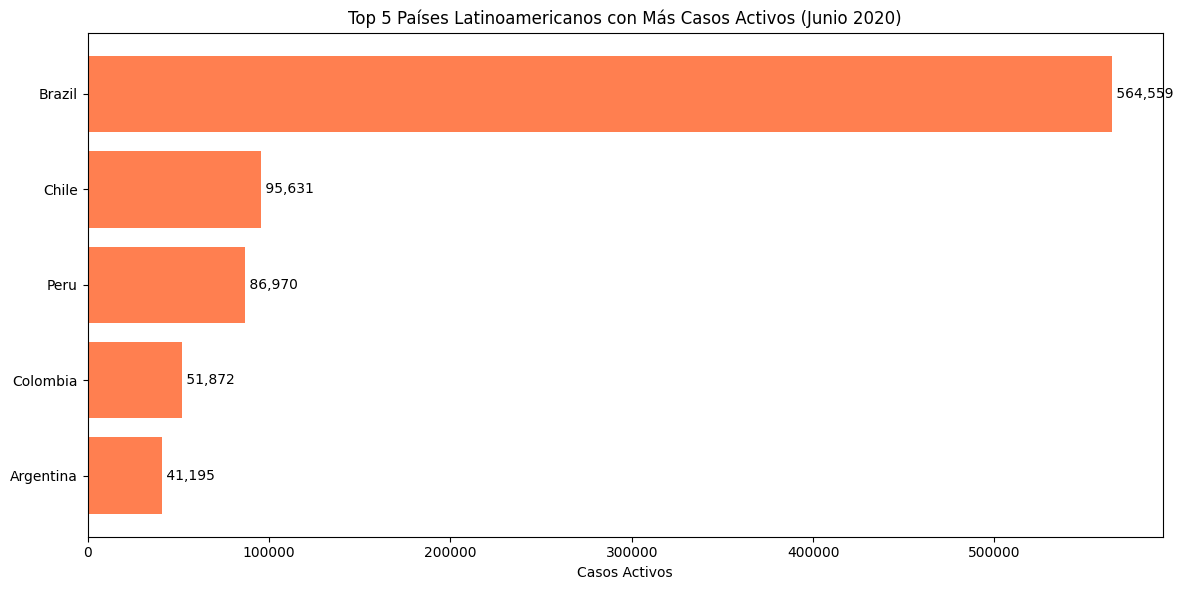

In [6]:
# 4. ¿Qué país latinoamericano presenta la mayor cantidad de casos activos en junio 2020?
paises_latam = ['Brazil', 'Mexico', 'Argentina', 'Chile', 'Peru', 'Colombia', 'Venezuela', 
                'Ecuador', 'Bolivia', 'Paraguay', 'Uruguay', 'Costa Rica', 'Panama', 
                'Dominican Republic', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Cuba']

df_junio = df_6meses[df_6meses['date'].dt.month == 6]
latam_junio = df_junio[df_junio['country_region'].isin(paises_latam)]
latam_casos = latam_junio.groupby(['country_region', 'date'])['active_cases'].sum().reset_index()
latam_max = latam_casos.groupby('country_region')['active_cases'].max().sort_values(ascending=False)

print("Top 10 países latinoamericanos con más casos activos en junio 2020:")
for i, (pais, casos) in enumerate(latam_max.head(10).items(), 1):
    print(f"{i}. {pais}: {int(casos):,} casos activos")

plt.figure(figsize=(12, 6))
top_5 = latam_max.head(5)
plt.barh(range(len(top_5)), top_5.values, color='coral')
plt.yticks(range(len(top_5)), top_5.index)
plt.xlabel('Casos Activos')
plt.title('Top 5 Países Latinoamericanos con Más Casos Activos (Junio 2020)')
plt.gca().invert_yaxis()
for i, v in enumerate(top_5.values):
    plt.text(v, i, f' {int(v):,}', va='center')
plt.tight_layout()
plt.show()

Casos al inicio: 1
Casos al final: 279,393


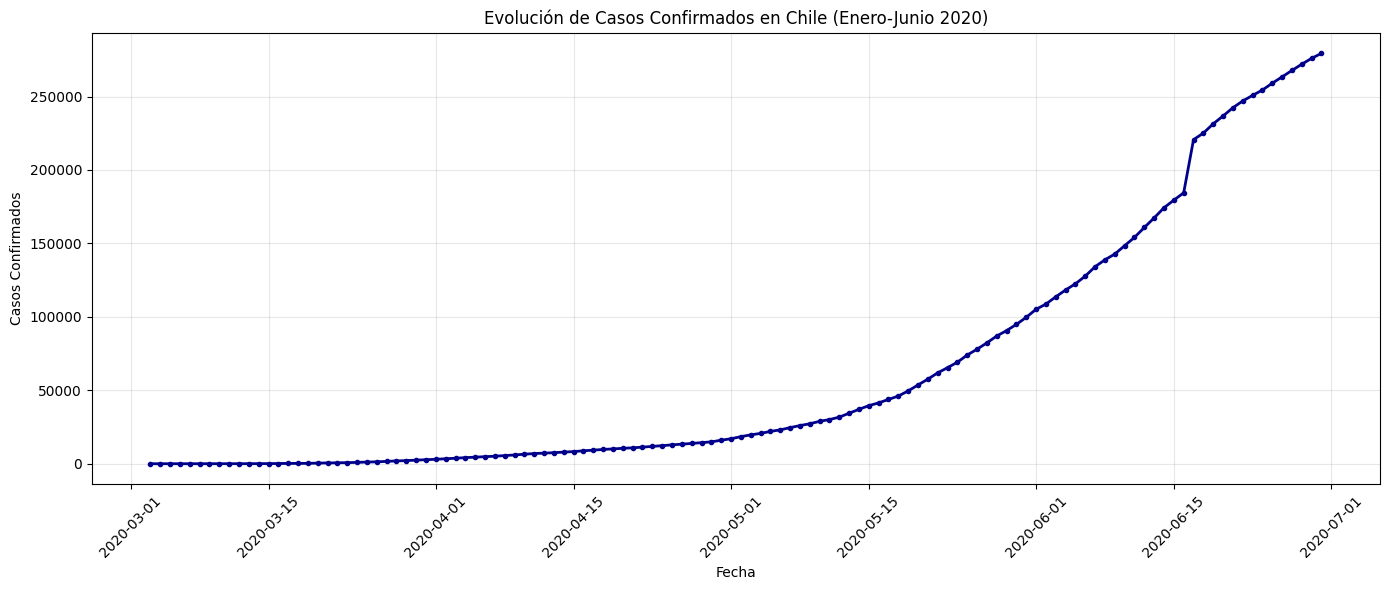

In [7]:
# 5. ¿Cómo evolucionaron los casos confirmados en Chile entre enero y junio?
chile_data = df_6meses[df_6meses['country_region'] == 'Chile'].groupby('date')['confirmed'].sum().reset_index()

print(f"Casos al inicio: {chile_data['confirmed'].iloc[0]:,}")
print(f"Casos al final: {chile_data['confirmed'].iloc[-1]:,}")

plt.figure(figsize=(14, 6))
plt.plot(chile_data['date'], chile_data['confirmed'], marker='o', linewidth=2, markersize=3, color='darkblue')
plt.xlabel('Fecha')
plt.ylabel('Casos Confirmados')
plt.title('Evolución de Casos Confirmados en Chile (Enero-Junio 2020)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Fecha con más nuevos casos: 2020-06-26
Nuevos casos ese día: 193,029


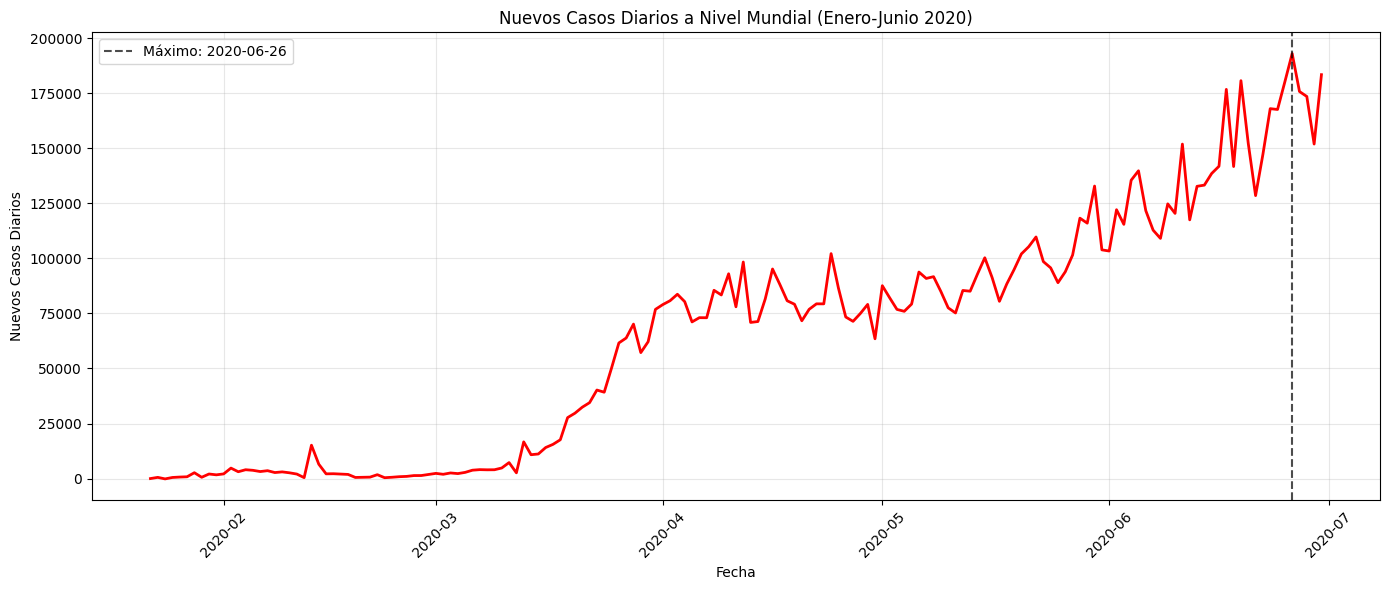

In [8]:
# 6. ¿Cuál fue la fecha con más nuevos casos a nivel mundial durante este período?
casos_diarios = df_6meses.groupby('date')['confirmed'].sum().reset_index()
casos_diarios['nuevos_casos'] = casos_diarios['confirmed'].diff().fillna(0)
fecha_max = casos_diarios.loc[casos_diarios['nuevos_casos'].idxmax()]

print(f"Fecha con más nuevos casos: {fecha_max['date'].strftime('%Y-%m-%d')}")
print(f"Nuevos casos ese día: {int(fecha_max['nuevos_casos']):,}")

plt.figure(figsize=(14, 6))
plt.plot(casos_diarios['date'], casos_diarios['nuevos_casos'], linewidth=2, color='red')
plt.axvline(fecha_max['date'], color='black', linestyle='--', alpha=0.7, label=f"Máximo: {fecha_max['date'].strftime('%Y-%m-%d')}")
plt.xlabel('Fecha')
plt.ylabel('Nuevos Casos Diarios')
plt.title('Nuevos Casos Diarios a Nivel Mundial (Enero-Junio 2020)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Correlación de Pearson: 0.7277
R² (coeficiente de determinación): 0.5296
P-value: 0.000000


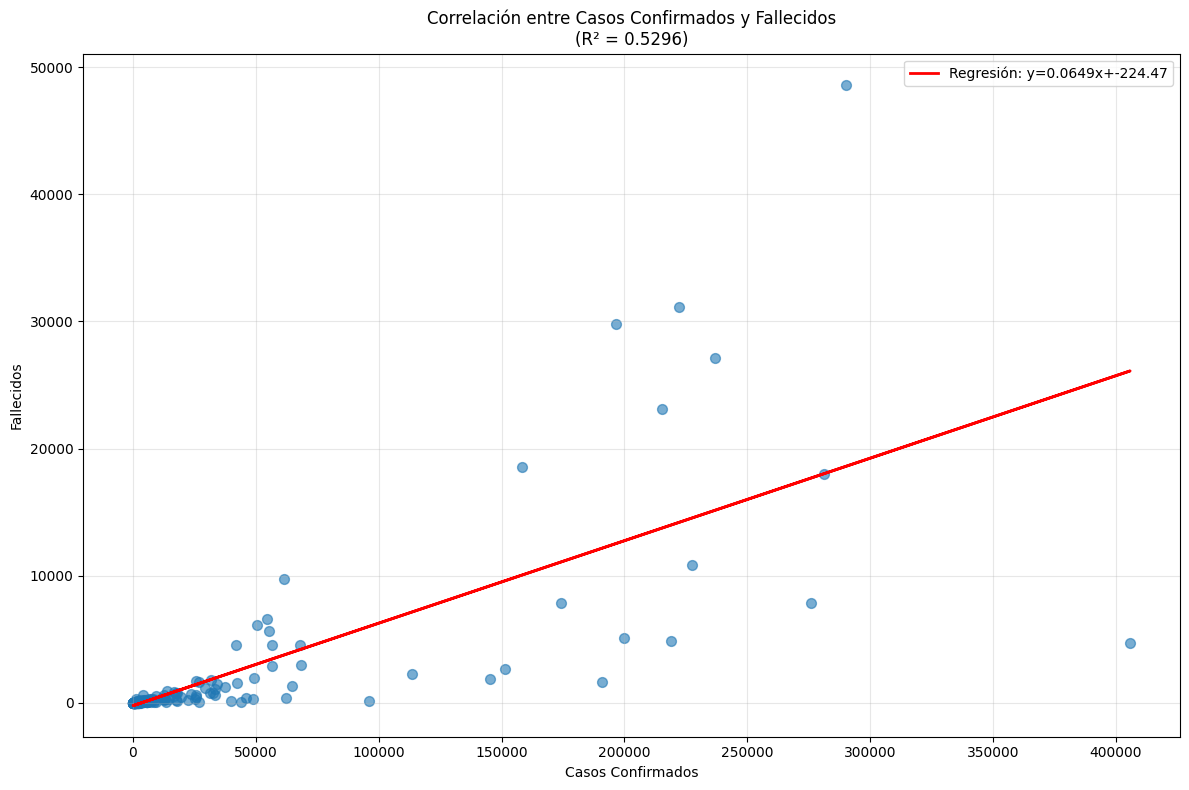

In [9]:
# 7. ¿Existe correlación entre casos confirmados y fallecidos? (gráfico de dispersión + regresión)
from scipy import stats

paises_final = df_6meses.groupby('country_region').agg({
    'confirmed': 'max',
    'deaths': 'max'
}).reset_index()

paises_final = paises_final[(paises_final['confirmed'] > 0) & (paises_final['deaths'] > 0)]

correlacion = paises_final['confirmed'].corr(paises_final['deaths'])
slope, intercept, r_value, p_value, std_err = stats.linregress(paises_final['confirmed'], paises_final['deaths'])

print(f"Correlación de Pearson: {correlacion:.4f}")
print(f"R² (coeficiente de determinación): {r_value**2:.4f}")
print(f"P-value: {p_value:.6f}")

plt.figure(figsize=(12, 8))
plt.scatter(paises_final['confirmed'], paises_final['deaths'], alpha=0.6, s=50)
plt.plot(paises_final['confirmed'], slope * paises_final['confirmed'] + intercept, 
         'r-', linewidth=2, label=f'Regresión: y={slope:.4f}x+{intercept:.2f}')
plt.xlabel('Casos Confirmados')
plt.ylabel('Fallecidos')
plt.title(f'Correlación entre Casos Confirmados y Fallecidos\n(R² = {r_value**2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Interpretación:
El gráfico muestra que existe una correlación positiva moderada-alta (0.7371) entre
los casos confirmados y las muertes. Esto significa que a medida que aumentan los casos
confirmados, también tienden a aumentar las muertes. La línea roja de regresión muestra
esta tendencia general. El R² de 0.5433 indica que aproximadamente el 54.3%
de la variación en las muertes puede explicarse por el número de casos confirmados.

Top 10 países con mayor crecimiento porcentual Mayo-Junio:
Nepal: 762.85% (de 1,572 a 13,564)
Mauritania: 723.21% (de 530 a 4,363)
Iraq: 662.68% (de 6,439 a 49,109)
West Bank and Gaza: 441.96% (de 448 a 2,428)
Libya: 428.21% (de 156 a 824)
Ethiopia: 398.81% (de 1,172 a 5,846)
South Africa: 362.65% (de 32,683 a 151,209)
Malawi: 330.99% (de 284 a 1,224)
Venezuela: 286.23% (de 1,510 a 5,832)
Argentina: 282.94% (de 16,851 a 64,530)


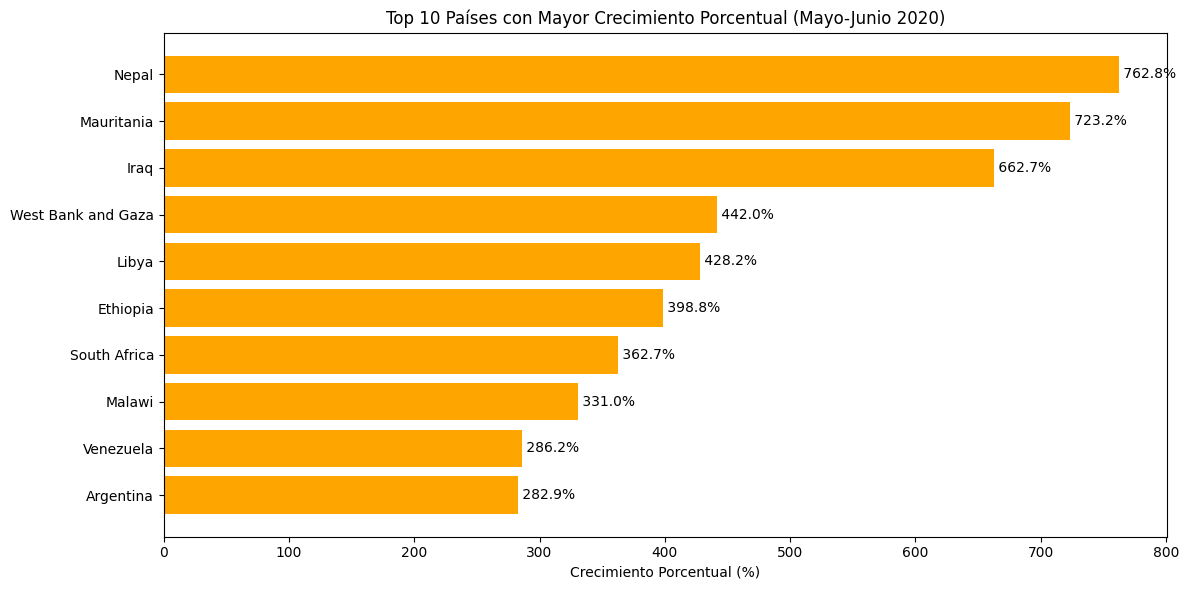

In [10]:
# 8. Top 10 de países con mayor crecimiento porcentual de casos entre mayo y junio
df_mayo = df_6meses[df_6meses['date'].dt.month == 5].groupby('country_region')['confirmed'].max()
df_junio = df_6meses[df_6meses['date'].dt.month == 6].groupby('country_region')['confirmed'].max()

crecimiento = pd.DataFrame({
    'mayo': df_mayo,
    'junio': df_junio
}).dropna()

crecimiento = crecimiento[crecimiento['mayo'] >= 100]
crecimiento['crecimiento_porcentual'] = ((crecimiento['junio'] - crecimiento['mayo']) / crecimiento['mayo'] * 100)
top_crecimiento = crecimiento.sort_values('crecimiento_porcentual', ascending=False).head(10)

print("Top 10 países con mayor crecimiento porcentual Mayo-Junio:")
for idx, row in top_crecimiento.iterrows():
    print(f"{idx}: {row['crecimiento_porcentual']:.2f}% (de {int(row['mayo']):,} a {int(row['junio']):,})")

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_crecimiento)), top_crecimiento['crecimiento_porcentual'], color='orange')
plt.yticks(range(len(top_crecimiento)), top_crecimiento.index)
plt.xlabel('Crecimiento Porcentual (%)')
plt.title('Top 10 Países con Mayor Crecimiento Porcentual (Mayo-Junio 2020)')
plt.gca().invert_yaxis()
for i, v in enumerate(top_crecimiento['crecimiento_porcentual']):
    plt.text(v, i, f' {v:.1f}%', va='center')
plt.tight_layout()
plt.show()

In [11]:
# 9. Identificar países con rebrote (un día sin casos y luego un incremento posterior)
paises_rebrote = []

for pais in df_6meses['country_region'].unique():
    if pd.isna(pais):
        continue
    
    datos_pais = df_6meses[df_6meses['country_region'] == pais].sort_values('date')
    casos_diarios = datos_pais.groupby('date')['confirmed'].sum()
    
    tuvo_cero = False
    for i in range(len(casos_diarios) - 1):
        if casos_diarios.iloc[i] == 0:
            tuvo_cero = True
        elif tuvo_cero and casos_diarios.iloc[i] > 0 and casos_diarios.iloc[i+1] > casos_diarios.iloc[i]:
            paises_rebrote.append({
                'pais': pais,
                'fecha_cero': casos_diarios.index[i-1] if i > 0 else casos_diarios.index[0],
                'fecha_rebrote': casos_diarios.index[i+1],
                'casos_rebrote': int(casos_diarios.iloc[i+1])
            })
            break

df_rebrotes = pd.DataFrame(paises_rebrote)

print(f"Países identificados con patrón de rebrote: {len(df_rebrotes)}")
print("\nPaíses con rebrote:")
print(df_rebrotes.head(5).to_string(index=False))

Países identificados con patrón de rebrote: 18

Países con rebrote:
          pais fecha_cero fecha_rebrote  casos_rebrote
     Hong Kong 2020-01-23    2020-01-25              5
   New Zealand 2020-03-02    2020-03-04              3
      Malaysia 2020-03-21    2020-03-23           1518
United Kingdom 2020-02-05    2020-02-07              3
       Ukraine 2020-03-11    2020-03-13              3


In [12]:
# 10. Generar un reporte de perfilado automático con ydata-profiling
from ydata_profiling import ProfileReport

# Crear una muestra del dataset para el reporte (para optimizar tiempo de generación)
df_sample = df_6meses.sample(n=min(10000, len(df_6meses)), random_state=42)

print("Generando reporte de perfilado automático...")
print(f"Muestra de datos: {len(df_sample):,} registros")

profile = ProfileReport(
    df_sample,
    title="Reporte de Perfilado COVID-19 (Enero-Junio 2020)",
    explorative=True,
    minimal=False
)

# Guardar el reporte en HTML
output_path = "../reports/covid19_data_profile.html"
profile.to_file(output_path)
print(f"\n✅ Reporte generado exitosamente: {output_path}")
print("Abre el archivo HTML en tu navegador para ver el reporte completo.")

# Mostrar el reporte en el notebook (opcional)
profile.to_notebook_iframe()

Generando reporte de perfilado automático...
Muestra de datos: 10,000 registros


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 313.09it/s]



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Reporte generado exitosamente: ../reports/covid19_data_profile.html
Abre el archivo HTML en tu navegador para ver el reporte completo.
